In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pafy
from fastai import *
from fastai.vision import *
from fastai.widgets import *
from PIL import Image as Img  
import numpy as np
torch.cuda.current_device()#個人PCのエラー対策用
import cv2
import matplotlib.pyplot as plt

# C3AE Model

In [4]:
path=r""
classes=['1', '10', '100', '101', '103', '105', '11', '110', '115', '116', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '95', '96', '99']
def conv(ni,nf,ks): return nn.Sequential(nn.Conv2d(ni,nf,ks,stride=1),nn.BatchNorm2d(32),nn.ReLU())

model= nn.Sequential(
    conv(3,32,3),
    nn.AvgPool2d(2,2),
    conv(32,32,3),
    nn.AvgPool2d(2,2),
    conv(32,32,3),
    nn.AvgPool2d(2,2),
    conv(32,32,3),
    nn.Conv2d(32,32,1),
    Flatten()
)

data = ImageDataBunch.single_from_classes(path, classes, ds_tfms=get_transforms(), size=64).normalize(imagenet_stats)
learn = Learner(data, model)
learn.load('C3AE_age1')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: C:\Users\12829\Desktop\deepblue\age prediction\UTKFace.tar\UTKFace;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: C:\Users\12829\Desktop\deepblue\age prediction\UTKFace.tar\UTKFace;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (5): A

# Camera

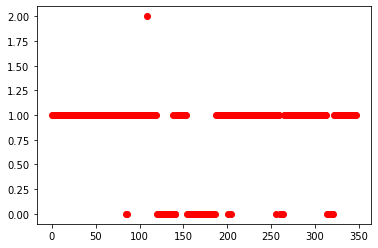

In [5]:
cap = cv2.VideoCapture(0)
face_detect = cv2.CascadeClassifier(r'haarcascade_frontalface_alt.xml')
num_list = []
while True:
    # カメラ読み込み
    flag, frame = cap.read()
    if flag == False:
        print("error")
        break

    # モノクロ画像転換
    gray = cv2.cvtColor(frame, code=cv2.COLOR_BGR2GRAY)

    # 顔検出
    face_zone = face_detect.detectMultiScale(gray, scaleFactor = 1.2, minNeighbors = 5)
    
    #type transform
    img=Image(pil2tensor(frame, dtype=np.float32).div_(255))
    #predction
    pred_class =str(learn.predict(img)[0])
    
    # 人数初期化
    num = 0
    
    #複数顔の処理
    for x, y, w, h in face_zone:
        num = num + 1
        #顔に矩形描画
        cv2.rectangle(frame, pt1 = (x, y), pt2 = (x+w, y+h), color = [0,255,0], thickness=2)
        #年齢テキスト追加
        cv2.putText(frame, pred_class, (x,y), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 1)
        
    # show
    cv2.putText(frame, "{}people".format(num), (10,50), cv2.FONT_HERSHEY_COMPLEX, 1, (142, 125, 52), 1)
    cv2.imshow('video', frame)
    num_list.append(num)
    # use space to quit
    if ord(' ') == cv2.waitKey(20):
        break

cap.release()
plt.plot(num_list,'ro')
plt.show()
# release
cv2.destroyAllWindows()


# Vedio

In [9]:
face_detect = cv2.CascadeClassifier(r'haarcascade_frontalface_alt.xml')
num_list = []
# 識別したいURL
url="https://www.youtube.com/watch?v=grEaluG1a0A"
vPafy= pafy.new(url)
play= vPafy.getbest(preftype="mp4")
cap= cv2.VideoCapture(play.url)
while True:
    ret, frame = cap.read()
    
    # モノクロ画像転換
    gray = cv2.cvtColor(frame, code=cv2.COLOR_BGR2GRAY)

    # 顔検出
    face_zone = face_detect.detectMultiScale(gray, scaleFactor = 1.2, minNeighbors = 5)
    
    # 人数
    num = 0
    
    #複数顔の処理
    for x, y, w, h in face_zone:
        
        face = frame[y:y+h, x:x+w]  # 顔ごと抽出

        #type transform
        img=Image(pil2tensor(face, dtype=np.float32).div_(255))
        #predction
        pred_class =str(learn.predict(img)[0])
        
        num = num + 1
        # 顔に矩形描画
        cv2.rectangle(frame, pt1 = (x, y), pt2 = (x+w, y+h), color = [0,255,0], thickness=2)
        #年齢テキスト追加
        cv2.putText(frame, pred_class, (x,y), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 1)
        
        
    # show frame
    cv2.putText(frame, "{}people".format(num), (10,50), cv2.FONT_HERSHEY_COMPLEX, 1, (142, 125, 52), 1)
    cv2.imshow('video', frame)
    num_list.append(num)
    # use space to quit
    if ord(' ') == cv2.waitKey(20):
        break
        
# release
cv2.destroyAllWindows()

In [ ]:
# 固まったら
cv2.destroyAllWindows()